In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

#from table_maker import *

import pickle

from functools import partial

from itertools import product
import more_itertools

from math import ceil

import warnings


In [77]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

In [3]:
def Unum(ξ, μ, α, γ, θ, Δ, c):
    return (1.0/2.0)*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((1.0/2.0)*(-np.exp(Δ)/(μ*c - 1) + 1.0/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((θ + (-( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + ((1.0/2.0)*μ*c - 1.0/2.0)*np.exp(-Δ) + 1.0/2.0)/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*np.exp(ξ/(μ*c)) + 1 - 1.0/2.0*np.exp(-Δ)*np.exp(-ξ)/(μ*c + 1) + (1.0/2.0)*np.exp(ξ)/(μ*c - 1))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)

def Anum(ξ, μ, α, γ, θ, Δ, c):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)

def find_root_indices(ys):
    # roots can be identified as a sign change from one point to the next.
    # if the product of two consective points is negative, then the sign changed.
    # if the product is zero, then one of the two points is the root
    root_mask = (ys[:-1]*ys[1:] <= 0) & (ys[1:]!=0) # locate roots
    root_indices = np.arange(len(ys)-1)[root_mask] # extract indices
    
    assert len(root_indices)%2 == 0 # ensure that there are an even number of roots
    left_roots = [root for root in root_indices[::2]]
    right_roots = [root for root in root_indices[1::2]]      
    for left_root, right_root in zip(left_roots, right_roots):
        assert ys[left_root]<0  and 0<ys[left_root+1]
        assert 0<ys[right_root] and ys[right_root+1]<0
    return root_indices

def refine_root(root_index, xs, ys, h, spatial_order):
    assert spatial_order >= 1
    if spatial_order == 1:
        return xs[root_index]
    # otherwise, interpolate and root-find
    stencil_size = spatial_order + 1
    half_stencil_size = stencil_size//2
    stencil = np.arange(  -half_stencil_size , -half_stencil_size + stencil_size)
    y_local = ys[root_index + stencil]
    coeffs = la.solve( np.array( [stencil**i for i in range(len(stencil))] ).T, y_local)

    my_f = lambda x: sum(c*x**i for (i,c) in enumerate(coeffs))
    d_coeffs = [i*c for (i,c) in enumerate(coeffs)][1:]
    my_df = lambda x: sum(c*x**i for (i,c) in enumerate(d_coeffs))

    my_root = 0
    for i in range(10):
        my_root -= my_f(my_root)/my_df(my_root)
    assert 0<= my_root and my_root <= 1 # interpolation failed
    return my_root*h + xs[root_index]

def refine_root_safe(root_index, xs, ys, h, spatial_order):
    try:
        root = refine_root(root_index, xs, ys, h, spatial_order)
    except:
        warnings.warn("Order %d interpolation failed. Reverting to Order 1 interpolation." % spatial_order)
        # linear interpolation will be safer
        root = refine_root(root_index, xs, ys, h, spatial_order=1)
    return root

def find_roots(xs, ys, h, spatial_order=4):
    return [ refine_root_safe(root_index, xs, ys, h, spatial_order=spatial_order) for root_index in  find_root_indices(ys) ]

def convolution(xs, ys, h, spatial_order):
    roots = find_roots(xs, ys, h, spatial_order)
    assert len(roots)%2 == 0 # ensure that there are an even number of roots
    left_roots = [root for root in roots[::2]]
    right_roots = [root for root in roots[1::2]]
    
    ret = xs*0
                   
    for root_left, root_right in zip(left_roots, right_roots):
        
        left_mask = xs <= root_left
        ret[left_mask] += .5*np.exp( xs[left_mask]) * (np.exp(-root_left) - np.exp(-root_right))

        right_mask = xs> root_right
        ret[right_mask] += .5*np.exp(-xs[right_mask]) * (np.exp(root_right) - np.exp(root_left))

        mid_mask =  ~(left_mask | right_mask)
        ret[mid_mask] += (2 - np.exp(root_left-xs[mid_mask]) - np.exp(xs[mid_mask]-root_right) )/2
    
    return ret

def RK4_step(F, x, t, u, dt):
    k1 = F(x, t, u)
    k2 = F(x, t+dt/2, u + dt/2*k1)
    k3 = F(x, t+dt/2, u + dt/2*k2)
    k4 = F(x, t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

def forward_Euler_step(F, x, t, u, dt):
    return u + F(x,t,u)*dt

def solution_sequence(x, t0, k, u0, F, time_integrator_step=RK4_step, tf=None):
    u = u0
    yield u
    t = t0
    step = 0
    while True:
        if tf is not None and t>=tf:
            return
        u = time_integrator_step(F, x, t, u, k)
        t += k
        yield u

# General semi-analytic forcing term
def F_general(x,t,u, spatial_order, μ, α, γ, θ, c, Δ):
    convo = convolution(x, u[0]-u[1]-θ, h, spatial_order)
    ret = np.array([
        1/μ * (-u[0] + convo),
        (-u[1] + γ*np.heaviside( u[0]-u[1]-θ, .5))/α
    ])
    return ret

def order(errors, hs):
    return [ np.log(e1/e2)/np.log(h1/h2) for e1, e2, h1, h2 in zip(errors[:-1], errors[1:], hs[:-1], hs[1:]) ]

In [4]:
with open('params00.pickle', 'rb') as f:
    param_dict = pickle.load(f)
    
θ = param_dict['θ']
α = param_dict['α']
γ = param_dict['γ']
μ = param_dict['μ']
c = param_dict['c']
Δ = param_dict['Δ']    

param_dict

{'μ': 1,
 'α': 5,
 'γ': 1,
 'θ': 0.1,
 'Δ': 32.15183309100653,
 'c': 3.999999999999946}

In [103]:
a, b_temp = -300, 300
t0, tf_temp = 0, 10

max_errors = []
l2_errors = []

k = 2**-10
hs = [2**-i for i in range(4, 11)]
for h_index, h in enumerate(hs):
    print(f'Computing h = {h} \t({h_index}/{len(hs)})' + ' '*10, end='\r')
    spatial_order = 1
    time_integrator_step = forward_Euler_step
    # time_integrator_step = RK4_step


    # initialze space
    n = ceil( (b_temp - a)/h ) + 1
    b = a + h*(n-1)
    xs = np.linspace(a, b, n)

    # adjust stopping time
    steps = ceil( (tf_temp-t0)/k )
    tf = t0 + k*steps

    # initialze traveling pulse solution
    u0 = np.zeros((2, n))
    u0[0] = Unum(xs, **param_dict)
    u0[1] = Anum(xs, **param_dict)

    # create forcing function
    F = partial(F_general, spatial_order=spatial_order, **param_dict)

    u = more_itertools.last(solution_sequence(xs, t0, k, u0, F, time_integrator_step=RK4_step, tf=tf))
    error = u[0] - Unum(xs-param_dict['c']*tf, **param_dict)
    max_errors.append( la.norm(error, ord=np.inf))
    l2_errors.append( la.norm(error, ord=2)*h)


print(order(max_errors, hs))
print(order(l2_errors, hs))

[0.9568924931625808, 0.9642560355708638, 0.9428482337313794, 0.9046191531409491, 0.7901091947055016, 0.6899424734746422]
[1.470887136859809, 1.4671040049583095, 1.4435489086396376, 1.405927910124268, 1.2817270212001288, 1.1826229660024516]


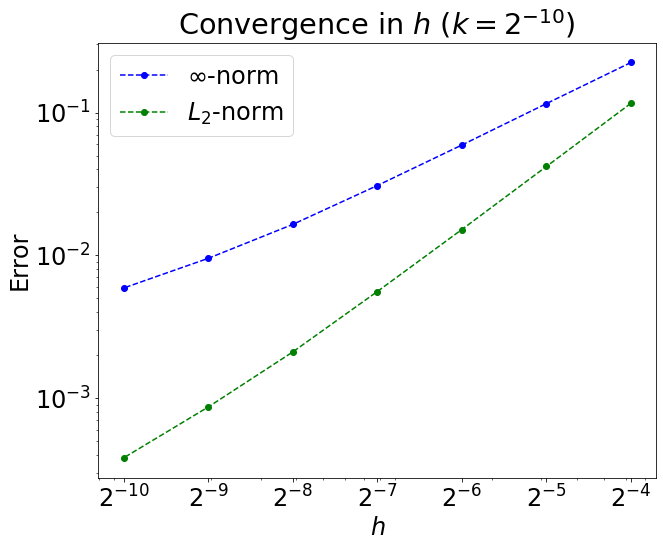

In [104]:
plt.figure(figsize=(10,8))
plt.loglog(hs, max_errors, 'bo--', label='$\infty$-norm')
plt.loglog(hs, l2_errors, 'go--', label='$L_2$-norm')

plt.xticks(hs, [f'$2^{{{h}}}$' for h in [int(np.log(h)/np.log(2))for h in hs]])
plt.title(f'Convergence in $h$ ($k=2^{{{int(np.log(k)/np.log(2))}}}$)')
plt.xlabel('$h$')
plt.ylabel('Error')
plt.legend()

plt.savefig('../reports/report20210729/convergence_in_h.png')

plt.show()

In [105]:
a, b_temp = -300, 300
t0, tf_temp = 0, 10

max_errors = []
l2_errors = []

h = 2**-10
ks = [2**-i for i in range(4, 11)]
for k_index, k in enumerate(ks):
    print(f'Computing k = {k} \t({k_index}/{len(ks)})' + ' '*10, end='\r')
    spatial_order = 1
    time_integrator_step = forward_Euler_step
    # time_integrator_step = RK4_step


    # initialze space
    n = ceil( (b_temp - a)/h ) + 1
    b = a + h*(n-1)
    xs = np.linspace(a, b, n)

    # adjust stopping time
    steps = ceil( (tf_temp-t0)/k )
    tf = t0 + k*steps

    # initialze traveling pulse solution
    u0 = np.zeros((2, n))
    u0[0] = Unum(xs, **param_dict)
    u0[1] = Anum(xs, **param_dict)

    # create forcing function
    F = partial(F_general, spatial_order=spatial_order, **param_dict)

    u = more_itertools.last(solution_sequence(xs, t0, k, u0, F, time_integrator_step=RK4_step, tf=tf))
    error = u[0] - Unum(xs-param_dict['c']*tf, **param_dict)
    max_errors.append( la.norm(error, ord=np.inf))
    l2_errors.append( la.norm(error, ord=2)*h)


print(order(max_errors, hs))
print(order(l2_errors, hs))

[0.769446207459361, 0.8368621034190192, 0.8673305860808139, 0.8045638851780677, 0.7091162507250337, 0.5648411870926702]
[0.7710578309209097, 0.8361941785312025, 0.8647522796689684, 0.7997085368107705, 0.7073571115015749, 0.5572762480211134]


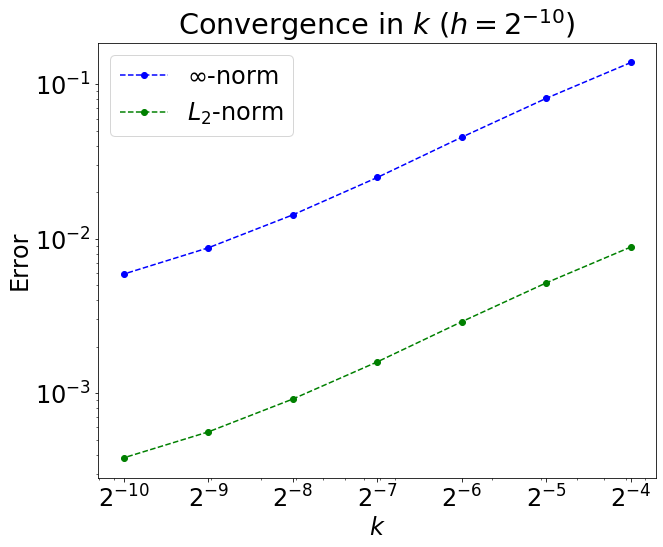

In [106]:
plt.figure(figsize=(10,8))
plt.loglog(ks, max_errors, 'bo--', label='$\infty$-norm')
plt.loglog(ks, l2_errors, 'go--', label='$L_2$-norm')

plt.xticks(ks, [f'$2^{{{i}}}$' for i in [int(np.log(k)/np.log(2))for k in ks]])
plt.title(f'Convergence in $k$ ($h=2^{{{int(np.log(h)/np.log(2))}}}$)')
plt.xlabel('$k$')
plt.ylabel('Error')
plt.legend()

plt.savefig('../reports/report20210729/convergence_in_k.png')

plt.show()

In [ ]:
a, b_temp = -300, 300
t0, tf_temp = 0, 10

max_errors = []
l2_errors = []

hs = [2**-i for i in range(4, 11)]
for h_index, h in enumerate(hs):
    print(f'Computing h = k = {h} \t({h_index}/{len(hs)})' + ' '*10, end='\r')
    k = h
    spatial_order = 1
    time_integrator_step = forward_Euler_step
    # time_integrator_step = RK4_step


    # initialze space
    n = ceil( (b_temp - a)/h ) + 1
    b = a + h*(n-1)
    xs = np.linspace(a, b, n)

    # adjust stopping time
    steps = ceil( (tf_temp-t0)/k )
    tf = t0 + k*steps

    # initialze traveling pulse solution
    u0 = np.zeros((2, n))
    u0[0] = Unum(xs, **param_dict)
    u0[1] = Anum(xs, **param_dict)

    # create forcing function
    F = partial(F_general, spatial_order=spatial_order, **param_dict)

    u = more_itertools.last(solution_sequence(xs, t0, k, u0, F, time_integrator_step=RK4_step, tf=tf))
    error = u[0] - Unum(xs-param_dict['c']*tf, **param_dict)
    max_errors.append( la.norm(error, ord=np.inf))
    l2_errors.append( la.norm(error, ord=2)*h)


print(order(max_errors, hs))
print(order(l2_errors, hs))

In [ ]:
plt.figure(figsize=(10,8))
plt.loglog(ks, max_errors, 'bo--', label='$\infty$-norm')
plt.loglog(ks, l2_errors, 'go--', label='$L_2$-norm')

plt.xticks(ks, [f'$2^{{{i}}}$' for i in [int(np.log(h)/np.log(2))for h in hs]])
plt.title(f'Convergence in $h$ and $k$')
plt.xlabel('$h=k$')
plt.ylabel('Error')
plt.legend()

plt.savefig('../reports/report20210729/convergence_in_hk.png')

plt.show()